In [9]:
%pylab inline
import numpy as np
import pandas as pd
import os
import Hamiltonian
import MoireLattice
from scipy import linalg as la
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [26]:
pathMAC="/Users/jfmv/Documents/Proyectos/Moire-Phonon_QMC/BM_bandstructure"
pathchow='/home/jfm343/Documents/Moire_phonon/BM_bandstructure'
pathpc='/home/juan/Documents/Projects/BM_bandstructure'
pathy=pathchow
# path=pathy+'/Mods/data20_mode_T_symmetry_a_alpha_0.5_beta_1.0_umklp_0_kappa_0.75_theta_0.01832595714594046.h5'
# df = pd.read_hdf(path)

In [27]:
# df_prime=df.loc[df['nu']==0]
# scatter(df_prime['kx'],df_prime['ky'], c=df_prime['bub'])
# colorbar()

In [28]:

# fillings=df['nu']
# cep=df['delt_cph']/21400
# plt.scatter(fillings, cep, c='b', label='lh')
# plt.plot(fillings, cep, c='k', ls='--')
# plt.legend()
# plt.xlabel(r"$\nu$")
# plt.ylabel(r"$\alpha/ c_L$")
# # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


In [29]:
Nu_fix=0.0

In [30]:
 #Lattice parameters 
#lattices with different normalizations 
Nsamp=10
theta=1.05*np.pi/180  # magic angle 
l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
[KX,KY]=lq.Generate_lattice()
Npoi=np.size(KX); print(Npoi, "numer of sampling lattice points")
[q1,q2,q3]=l.q
q=la.norm(q1)
umkl=3
print(f"taking {umkl} umklapps")
VV=lq.boundary()


#phonon parameters
a_graphene=2.458*(1e-10) #in meters this is the lattice constant NOT the carbon-carbon distance
e_el=1.6021766*(10**(-19))  #in joule/ev
c_light=299792458 #m/s
M=1.99264687992e-26 * (c_light*c_light/e_el) # [in units of eV]
mass=M/(c_light**2) # in ev *s^2/m^2
hhbar=6.582119569e-16 #(in eV s)
alpha_ep=2 # in ev
beta_ep=4 #in ev SHOULD ALWAYS BE GREATER THAN ZERO



#calculating effective coupling
A1mbz=lq.VolMBZ*((q**2)/(a_graphene**2))
AWZ_graphene=np.sqrt(3)*a_graphene*a_graphene/2
A1bz=(2*np.pi)**2 / AWZ_graphene
alpha_ep_effective=np.sqrt(1/2)*np.sqrt(A1mbz/A1bz)*alpha_ep #sqrt 1/2 from 2 atoms per unit cell in graphene
beta_ep_effective=np.sqrt(1/2)*np.sqrt(A1mbz/A1bz)*beta_ep #sqrt 1/2 from 2 atoms per unit cell in graphene
alpha_ep_effective_tilde=alpha_ep_effective/beta_ep_effective
beta_ep_effective_tilde=beta_ep_effective/beta_ep_effective


gp2=4


starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.0059125423431396484  s
91 numer of sampling lattice points
taking 3 umklapps


## For the twist angle 0.75

In [36]:
kappa=0.75
path=pathy+'/data/thetasweep_kappa_'+str(kappa)+'_N30'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
tdos=[]
thetass=[]
eners=[]
fils=[]
for i, pat in enumerate(subpaths):
    # print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)

    

    Nsamp=100
    theta=dff['theta'][0]
    l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
    lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
    [q1,q2,q3]=l.q
    q=la.norm(q1)
    
    #JY params 
    hbvf = (3/(2*np.sqrt(3)))*2.7; # eV
    hvkd=hbvf*q
    up = 0.105; # eV
    u = kappa*up; # eV
    alpha=up/hvkd
    alph=alpha
    PH=True
    nbands=2

    # print("Loading  ..........")
    with open(fulpath+'/dispersions/Edisp_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'_kappa_'+str(kappa)+'.npy', 'rb') as f:
        Ene_valley_plus_dos=np.load(f)
    with open(fulpath+'/dispersions/Edism_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'_kappa_'+str(kappa)+'.npy', 'rb') as f:
        Ene_valley_min_dos=np.load(f)

    hpl=Hamiltonian.Ham_BM_p(hvkd, alph, 1, lq, kappa, PH)
    hmin=Hamiltonian.Ham_BM_m(hvkd, alph, -1, lq, kappa, PH)

    Ndos=80
    ldos=MoireLattice.MoireTriangLattice(Ndos,theta,2)
    disp=Hamiltonian.Dispersion( ldos, nbands, hpl, hmin)
    [earr, dos, f2 ]=disp.DOS(Ene_valley_plus_dos,Ene_valley_min_dos)


    NN=2000
    mine=earr[1]
    maxe=earr[-2]
    mus=np.linspace(mine,maxe, NN)
    dosarr=f2(mus)
    de=mus[1]-mus[0]

    #FILLING FOR EACH CHEMICAL POTENTIAL
    ndens=[]
    for mu_ind in range(NN):
        N=np.trapz(dosarr[0:mu_ind])*de
        ndens.append(N)
            
    nn=np.array(ndens)
    nn=8*(nn/nn[-1])  - 4

    tdos.append(dosarr)
    thetass.append(theta)
    eners.append(mus)
    fils.append(nn)
    #
df=pd.concat(frames).sort_values(['theta', 'nu'])

thetass,tdos,eners,fils = zip(*sorted(zip(thetass,tdos,eners,fils)))


starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.24512290954589844  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999931
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.23652100563049316  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000133
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.23449349403381348  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000078
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.22301697731018066  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.99999999999998
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.20633602142333984  s
number of bands in density of states calculation, 2
sum of the hist, normed?

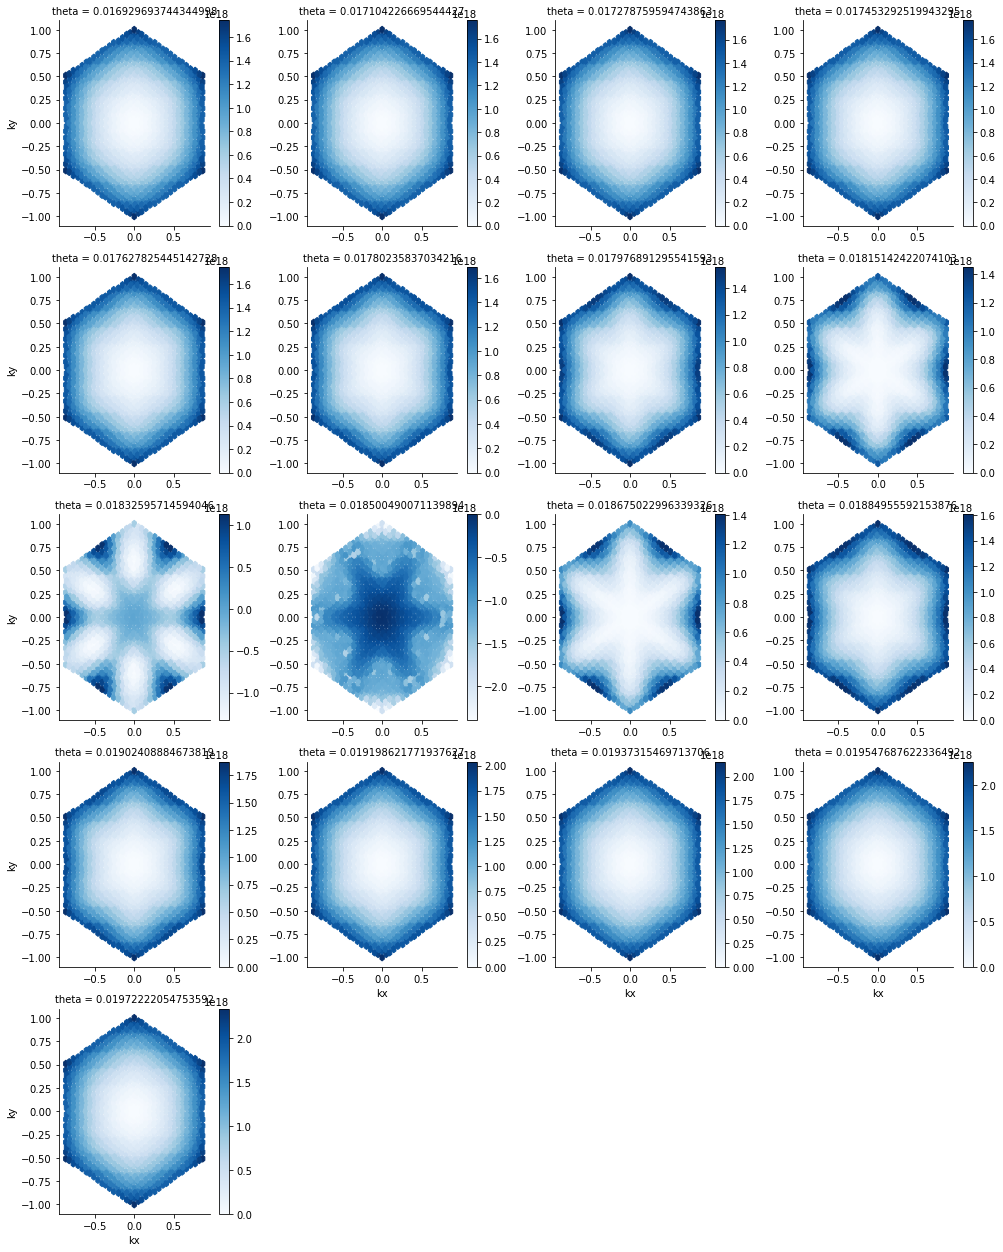

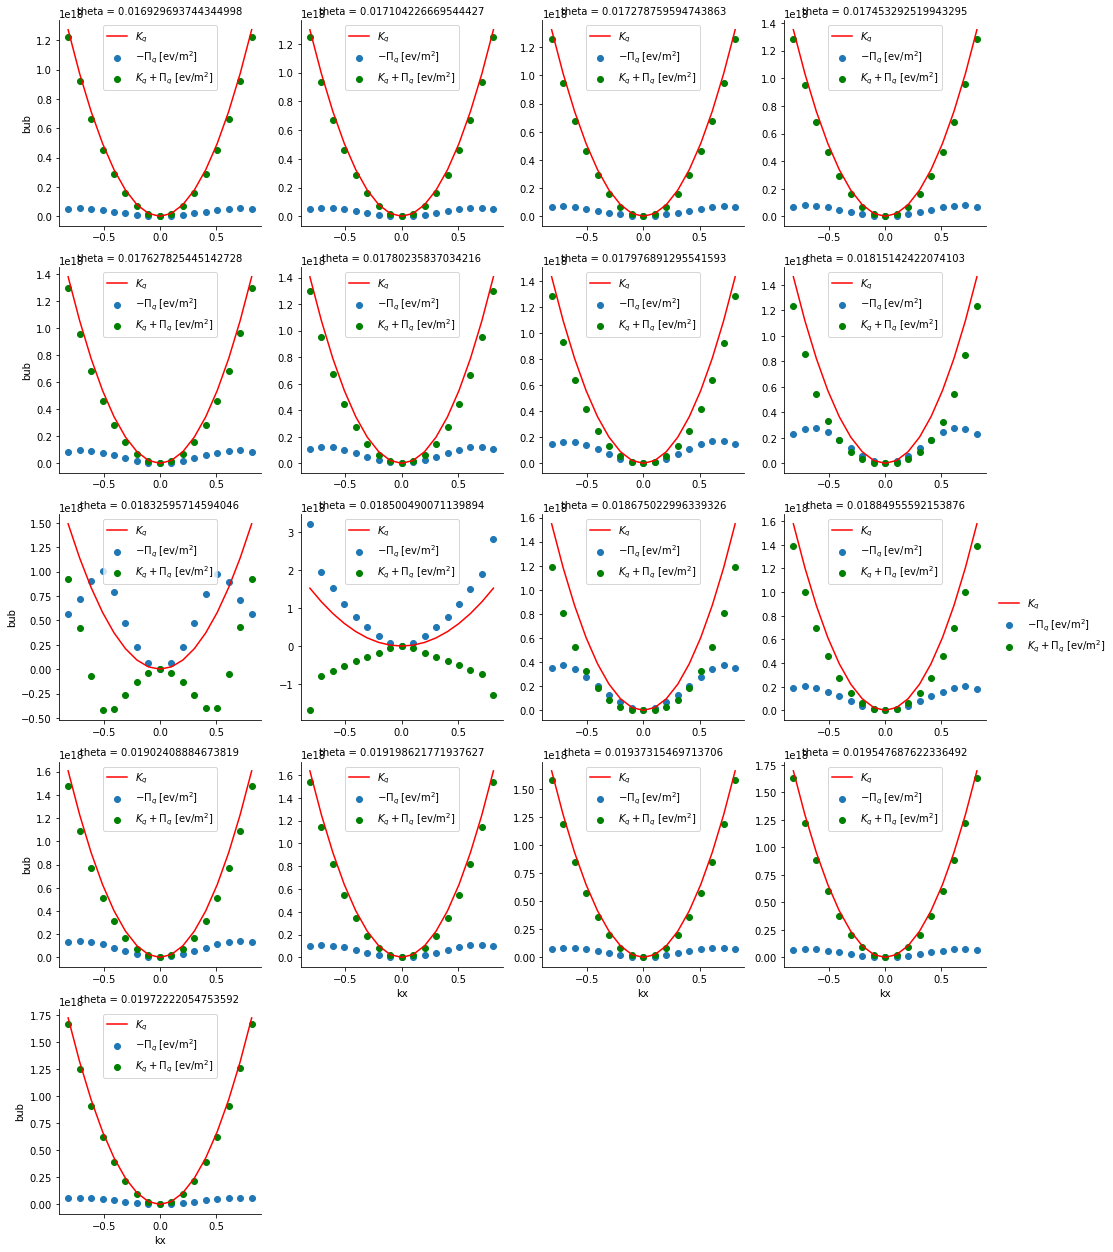

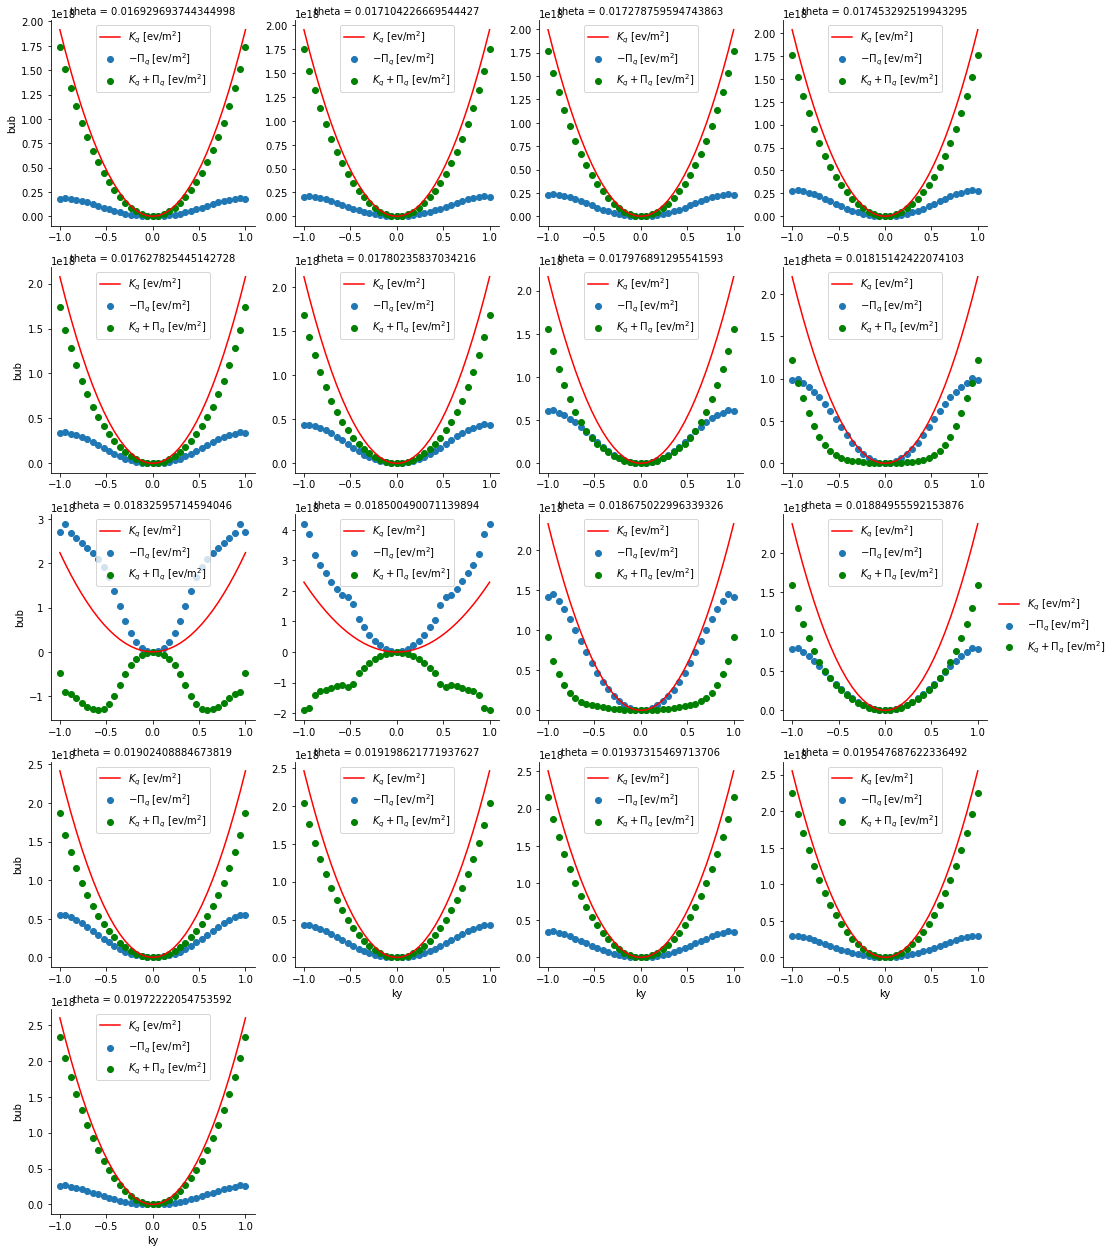

In [38]:
# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()

cTrans=13600
df_one_temp=df.loc[df['nu'] == Nu_fix]
def draw_heatmap(*args, **kwargs):
    
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = data.loc[:,args[1]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(th/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    d3 = cons*(cTrans**2) * (d2**2 +d1**2)-gp2*data.loc[:,args[2]]
    color_map = plt.cm.get_cmap('Blues')

    plt.hexbin(d1,d2 ,C=d3,sizes=10*np.ones(np.size(d1)), cmap=color_map)
    plt.colorbar()

    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'ky', 'bub','theta', cbar=False, square = True)
# get figure background color


# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()
df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['ky'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(th/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cTrans**2)*d1*d1, c='r', label=r'$K_q$')
    plt.scatter(d1,cons*(cTrans**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color


df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['kx'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(th/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cTrans**2)*d1*d1, c='r', label=r'$K_q$ [ev/m$^2$]')
    plt.scatter(d1,cons*(cTrans**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'ky', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color



In [33]:
kappa=0.75
path=pathy+'/data/thetasweep_kappa_'+str(kappa)+'_L_N30'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
tdos=[]
thetass=[]
eners=[]
fils=[]
for i, pat in enumerate(subpaths):
    # print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)

    

    Nsamp=100
    theta=dff['theta'][0]
    l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
    lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
    [q1,q2,q3]=l.q
    q=la.norm(q1)
    
    #JY params 
    hbvf = (3/(2*np.sqrt(3)))*2.7; # eV
    hvkd=hbvf*q
    up = 0.105; # eV
    u = kappa*up; # eV
    alpha=up/hvkd
    alph=alpha
    PH=True
    nbands=2

    # print("Loading  ..........")
    with open(fulpath+'/dispersions/Edisp_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'_kappa_'+str(kappa)+'.npy', 'rb') as f:
        Ene_valley_plus_dos=np.load(f)
    with open(fulpath+'/dispersions/Edism_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'_kappa_'+str(kappa)+'.npy', 'rb') as f:
        Ene_valley_min_dos=np.load(f)

    hpl=Hamiltonian.Ham_BM_p(hvkd, alph, 1, lq, kappa, PH)
    hmin=Hamiltonian.Ham_BM_m(hvkd, alph, -1, lq, kappa, PH)

    Ndos=80
    ldos=MoireLattice.MoireTriangLattice(Ndos,theta,2)
    disp=Hamiltonian.Dispersion( ldos, nbands, hpl, hmin)
    [earr, dos, f2 ]=disp.DOS(Ene_valley_plus_dos,Ene_valley_min_dos)


    NN=2000
    mine=earr[1]
    maxe=earr[-2]
    mus=np.linspace(mine,maxe, NN)
    dosarr=f2(mus)
    de=mus[1]-mus[0]

    #FILLING FOR EACH CHEMICAL POTENTIAL
    ndens=[]
    for mu_ind in range(NN):
        N=np.trapz(dosarr[0:mu_ind])*de
        ndens.append(N)
            
    nn=np.array(ndens)
    nn=8*(nn/nn[-1])  - 4

    tdos.append(dosarr)
    thetass.append(theta)
    eners.append(mus)
    fils.append(nn)
    #
df=pd.concat(frames).sort_values(['theta', 'nu'])

thetass,tdos,eners,fils = zip(*sorted(zip(thetass,tdos,eners,fils)))



starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.20567750930786133  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000151
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.21057486534118652  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999962
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.20650982856750488  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.99999999999987
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.2071847915649414  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.9999999999999964
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.20730066299438477  s
number of bands in density of states calculation, 2
sum of the hist, normed?

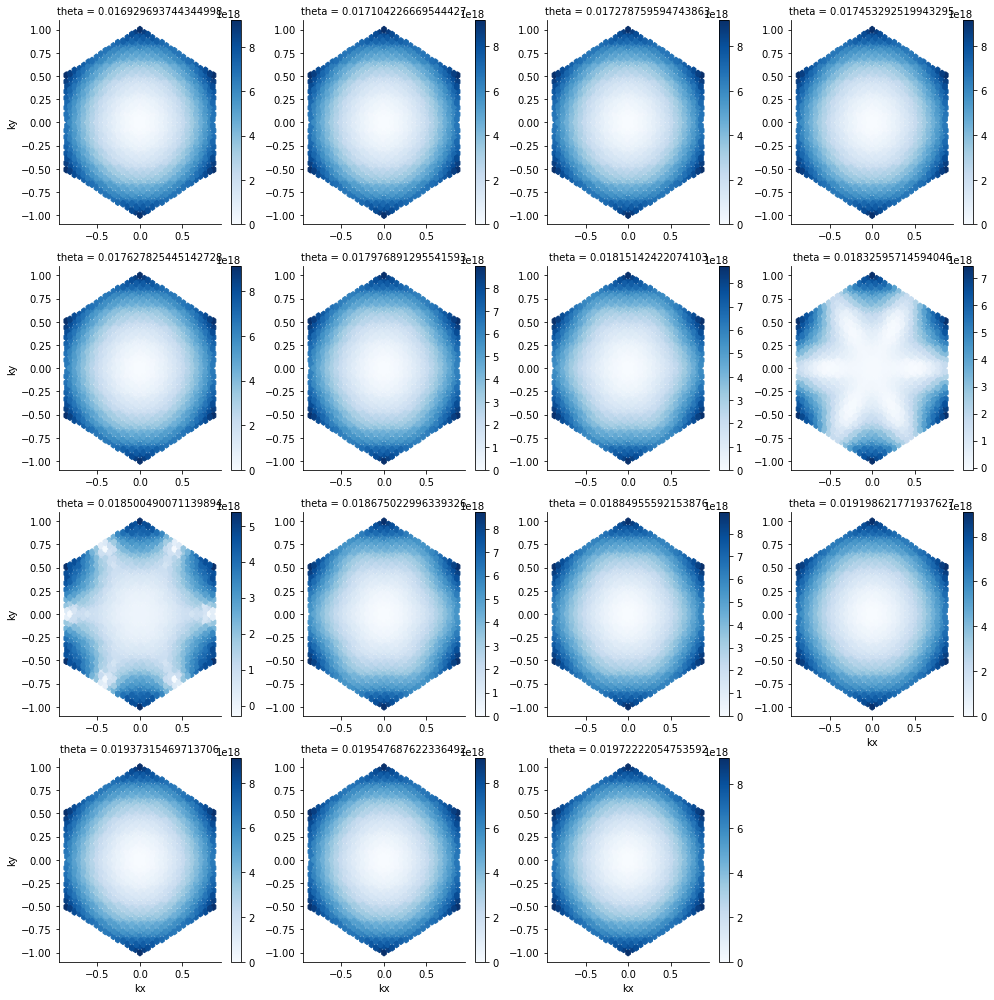

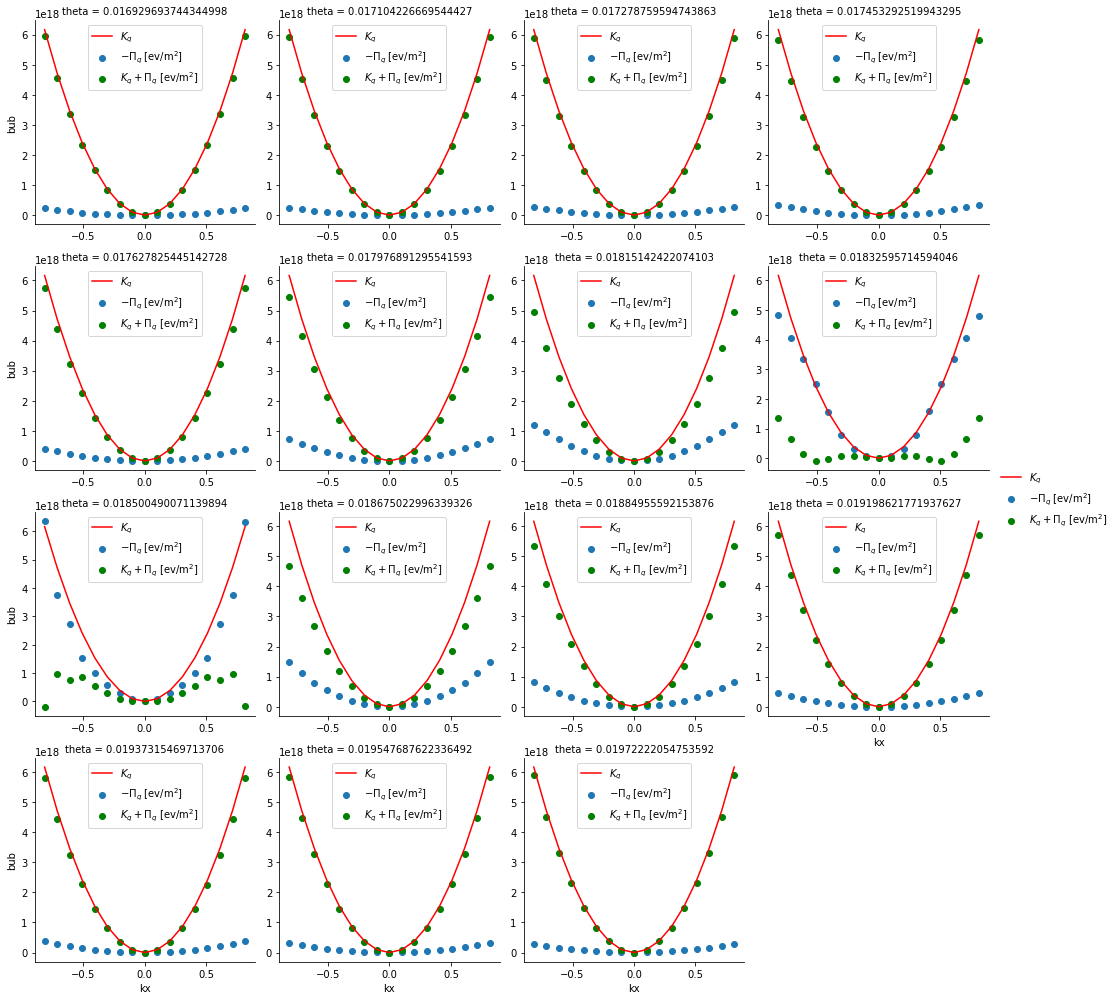

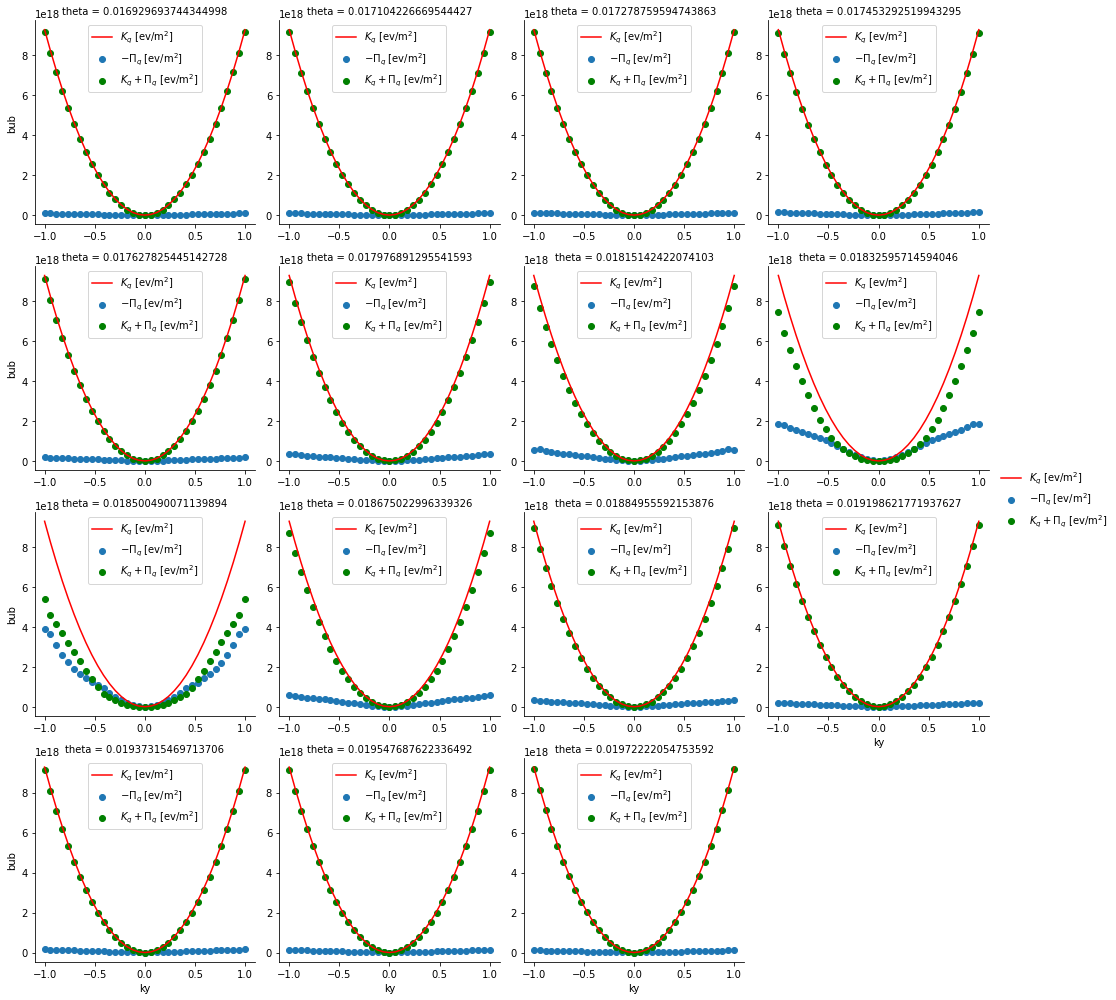

In [34]:
# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()

cLong=27400
df_one_temp=df.loc[df['nu'] == Nu_fix]
def draw_heatmap(*args, **kwargs):
    
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = data.loc[:,args[1]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    d3 = cons*(cLong**2) * (d2**2 +d1**2)-gp2*data.loc[:,args[2]]
    color_map = plt.cm.get_cmap('Blues')
    plt.hexbin(d1,d2 ,C=d3,sizes=10*np.ones(np.size(d1)), cmap=color_map)
    plt.colorbar()

    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'ky', 'bub', cbar=False, square = True)
# get figure background color


# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()
df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['ky'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cLong**2)*d1*d1, c='r', label=r'$K_q$')
    plt.scatter(d1,cons*(cLong**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color


df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['kx'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cLong**2)*d1*d1, c='r', label=r'$K_q$ [ev/m$^2$]')
    plt.scatter(d1,cons*(cLong**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'ky', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color


In [ ]:
# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()
theta=
cLong=27400
df_one_temp=df.loc[df['theta'] == Nu_fix]
def draw_heatmap(*args, **kwargs):
    
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = data.loc[:,args[1]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    d3 = cons*(cLong**2) * (d2**2 +d1**2)-gp2*data.loc[:,args[2]]
    color_map = plt.cm.get_cmap('Blues')
    plt.hexbin(d1,d2 ,C=d3,sizes=10*np.ones(np.size(d1)), cmap=color_map)
    plt.colorbar()

    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='nu',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'ky', 'bub', cbar=False, square = True)
# get figure background color


# # Generate a set of sample data
# np.random.seed(0)
# indices = pd.MultiIndex.from_product((range(5), range(5), range(5)),
#  names=('label0', 'label1', 'label2'))
# data = pd.DataFrame(np.random.uniform(0, 100, size=len(indices)),
#  index=indices, columns=('value',)).reset_index()
df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['ky'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cLong**2)*d1*d1, c='r', label=r'$K_q$')
    plt.scatter(d1,cons*(cLong**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'kx', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color


df_one_temp=df.loc[(df['nu'] == Nu_fix) & (df['kx'] == 0.0)]
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d1 = data.loc[:,args[0]]
    d2 = gp2*data.loc[:,args[1]]
    d3 = data.loc[:,args[2]]
    th = data.loc[:,args[3]]
    q0=2*np.sin(theta/2)*(4*np.pi/3)
    cons=mass*q0*q0/(a_graphene*a_graphene)
    plt.scatter(d1,d2,label=r'$-\Pi_q$ [ev/m$^2$]')
    # plt.plot(d1, cons*d1*d1*d3*d3)
    plt.plot(d1, cons*(cLong**2)*d1*d1, c='r', label=r'$K_q$ [ev/m$^2$]')
    plt.scatter(d1,cons*(cLong**2)*d1*d1-d2,c='g',label=r'$K_q+\Pi_q$ [ev/m$^2$]')
    plt.legend()
    # plt.tricontourf(kx,ky ,d3,annot=True, **kwargs)


fg = sns.FacetGrid(df_one_temp, col='theta',height=3.5, col_wrap=4, sharey=False, sharex=False)
fg.map_dataframe(draw_heatmap, 'ky', 'bub', 'delt_cph','theta', cbar=False, square = True)
fg.add_legend()
for ax in fg.axes.ravel():
    ax.legend()
# get figure background color